# Processing Time Series (GEE and XArray)

## **Overview**

This is a demonstration of how we can use the [XEE](https://github.com/google/Xee) package to extract time-series images from Earth Engine and then use XArray to apply smoothing and interpolation and save the processed images as GeoTIFF files locally.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
    !pip install rioxarray


In [3]:
%pip install xee -q
%pip install rioxarray -q

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
import ee
import xarray
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np

In [6]:
os.getcwd()

'c:\\Users\\coach\\Documents\\scratch'

In [7]:
output_folder = 'output'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
ee.Authenticate()

In [8]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

We start with the MODIS Vegetation Indices Version 6.1 data. We pre-process the data by applying cloud masking and pixel scaling.

In [9]:
modis = ee.ImageCollection('MODIS/061/MOD13Q1')

startDate = ee.Date.fromYMD(2020, 1, 1)
endDate = startDate.advance(2, 'year')
filtered = modis.filter(ee.Filter.date(startDate, endDate))

# Cloud Masking
def bitwiseExtract(input, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return input.rightShift(fromBit).bitwiseAnd(mask)

def maskSnowAndClouds(image):
  summaryQa = image.select('SummaryQA')
  # Select pixels which are less than or equals to 1 (0 or 1)
  qaMask = bitwiseExtract(summaryQa, 0, 1).lte(1)
  maskedImage = image.updateMask(qaMask)
  return maskedImage.copyProperties(image, ['system:index', 'system:time_start'])

# MODIS VI values come as VI x 10000 that need to be scaled by 0.0001
def scaleBands(image):
  scaled = image.multiply(0.0001)
  return scaled.copyProperties(image, ['system:index', 'system:time_start'])

# Apply the function to all images in the collection
maskedCol = filtered \
  .map(maskSnowAndClouds) \
  .map(scaleBands)


Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the 'ee' engine.

Our region of interest is in South India with the UTM Zone 46N. So we request the pixels in EPSG:32643 at 250m resolution.

In [10]:
aoi = ee.Geometry.Rectangle(77, 12, 79, 15)

ds = xarray.open_dataset(
    maskedCol,
    engine='ee',
    crs='EPSG:32643',
    scale=250,
    geometry=aoi,
)

THe result is a XArray Dataset containing the image time-series.

In [11]:
ds

<xarray.Dataset>
Dimensions:          (time: 46, X: 851, Y: 1341)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2021-12-19
  * X                (X) float32 77.03 77.03 77.03 77.03 ... 79.0 79.0 79.0
  * Y                (Y) float32 15.03 15.02 15.02 15.02 ... 12.0 12.0 12.0
Data variables:
    NDVI             (time, X, Y) float64 ...
    EVI              (time, X, Y) float64 ...
    DetailedQA       (time, X, Y) float64 ...
    sur_refl_b01     (time, X, Y) float64 ...
    sur_refl_b02     (time, X, Y) float64 ...
    sur_refl_b03     (time, X, Y) float64 ...
    sur_refl_b07     (time, X, Y) float64 ...
    ViewZenith       (time, X, Y) float64 ...
    SolarZenith      (time, X, Y) float64 ...
    RelativeAzimuth  (time, X, Y) float64 ...
    DayOfYear        (time, X, Y) float64 ...
    SummaryQA        (time, X, Y) float64 ...
Attributes:
    crs:      EPSG:32643

Select the 'NDVI' band.

In [12]:
original_time_series = ds.NDVI.chunk(dict(X=100, Y=100, time=-1))
original_time_series

<xarray.DataArray 'NDVI' (time: 46, X: 851, Y: 1341)>
dask.array<xarray-<this-array>, shape=(46, 851, 1341), dtype=float64, chunksize=(46, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2021-12-19
  * X        (X) float32 77.03 77.03 77.03 77.03 77.04 ... 78.99 79.0 79.0 79.0
  * Y        (Y) float32 15.03 15.02 15.02 15.02 15.02 ... 12.01 12.0 12.0 12.0
Attributes:
    id:             NDVI
    data_type:      {'type': 'PixelType', 'precision': 'double', 'min': -3.27...
    dimensions:     [172800, 67200]
    crs:            SR-ORG:6974
    crs_transform:  [231.65635826395825, 0, -20015109.354, 0, -231.6563582639...

## Interpolate and Smooth the time-series

We use XArray's excellent time-series processing functionality to fill the cloud-masked pixels with linearly interpolated values from temporal neighbors. We also apply a moving-window smoothing to remove noise.

In [13]:
time_series_interpolated = original_time_series.interpolate_na('time', use_coordinate=False)
time_series_smooth = time_series_interpolated.rolling(time=3, center=True).mean()
time_series_smooth

<xarray.DataArray 'NDVI' (time: 46, X: 851, Y: 1341)>
dask.array<truediv, shape=(46, 851, 1341), dtype=float64, chunksize=(45, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2021-12-19
  * X        (X) float32 77.03 77.03 77.03 77.03 77.04 ... 78.99 79.0 79.0 79.0
  * Y        (Y) float32 15.03 15.02 15.02 15.02 15.02 ... 12.01 12.0 12.0 12.0
Attributes:
    id:             NDVI
    data_type:      {'type': 'PixelType', 'precision': 'double', 'min': -3.27...
    dimensions:     [172800, 67200]
    crs:            SR-ORG:6974
    crs_transform:  [231.65635826395825, 0, -20015109.354, 0, -231.6563582639...

## Plot and Extract the Time-Series at a Single Location

In [14]:
original_ts = original_time_series.interp(Y=13.16, X=77.35)
smooth_ts = time_series_smooth.interp(Y=13.16, X=77.35)

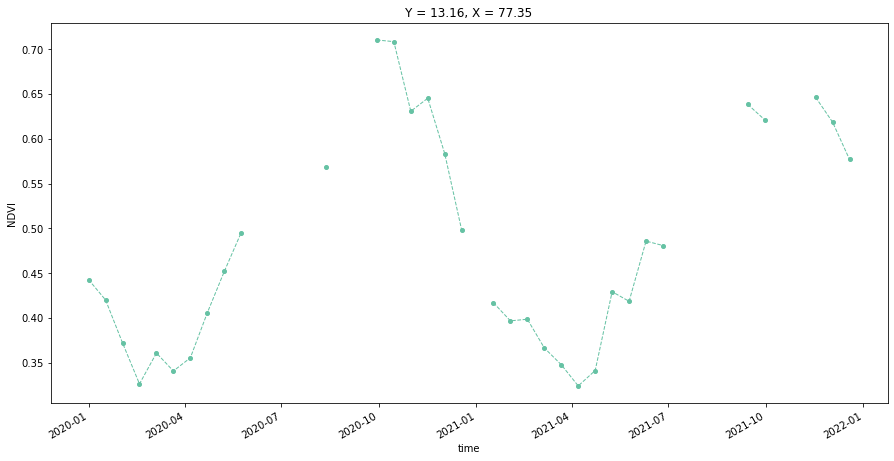

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4)
plt.show()

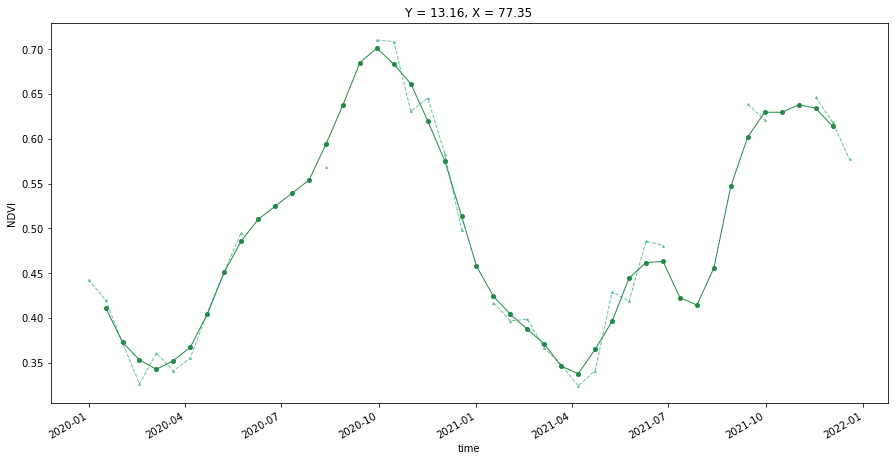

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
smooth_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
plt.show()

In [17]:
df = smooth_ts.to_pandas()
df

time
2020-01-01         NaN
2020-01-17    0.411618
2020-02-02    0.372851
2020-02-18    0.353111
2020-03-05    0.342659
2020-03-21    0.352374
2020-04-06    0.367334
2020-04-22    0.404349
2020-05-08    0.450950
2020-05-24    0.485693
2020-06-09    0.509947
2020-06-25    0.524582
2020-07-11    0.539217
2020-07-27    0.553851
2020-08-12    0.594015
2020-08-28    0.637707
2020-09-13    0.684928
2020-09-29    0.701124
2020-10-15    0.683015
2020-10-31    0.661353
2020-11-16    0.619739
2020-12-02    0.575580
2020-12-18    0.513290
2021-01-01    0.457791
2021-01-17    0.423995
2021-02-02    0.404082
2021-02-18    0.387272
2021-03-06    0.370954
2021-03-22    0.346152
2021-04-07    0.337757
2021-04-23    0.364919
2021-05-09    0.396391
2021-05-25    0.444519
2021-06-10    0.461691
2021-06-26    0.463058
2021-07-12    0.422669
2021-07-28    0.414334
2021-08-13    0.455774
2021-08-29    0.546988
2021-09-14    0.602080
2021-09-30    0.629562
2021-10-16    0.629434
2021-11-01    0.637820
2021-1

In [ ]:
output_filename = 'smoothed_time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.reset_index().to_csv(output_filepath, index=False)

## Download Smoothed Time-Series Images

Save the original time-series images using `rioxarray` as GeoTIFF files.

In [ ]:
for time in original_time_series.time.values:
  image = original_time_series.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'Y': 'y', 'X': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs('EPSG:4326')

  date = np.datetime_as_string(time, unit='D')
  output_file = f'original_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')

Save the smoothed time-series images.

In [ ]:
for time in time_series_smooth.time.values:
  image = time_series_smooth.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'Y': 'y', 'X': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs('EPSG:4326')

  date = np.datetime_as_string(time, unit='D')
  output_file = f'smoothed_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')
